# Example: mesh a delineated watershed

Here we mesh the [Coweeta Hydrologic Laboratory](https://www.srs.fs.usda.gov/coweeta/) as an example of how to pull data in from default locations and generate a fully functional ATS mesh.

This might be the worst example to use to learn how to use Watershed Workflows.  But it is useful to demonstrate the breadth of problems this project was intended to solve.

This includes a range of datasets:

* NHD Plus for river network
* NRCS soils data for soil types
* NLCD for land cover/transpiration/rooting depths
* NED for elevation

In [36]:
%matplotlib inline
# %matplotlib notebook

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [129]:
import os,sys
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
from matplotlib_scalebar.scalebar import ScaleBar
import shapely
import logging
import fiona

import workflow
import workflow.source_list
import workflow.ui
import workflow.colors
import workflow.condition
import workflow.mesh
import workflow.split_hucs

workflow.ui.setup_logging(1,None)
figsize = (6,6)
figsize_3d = (8,6)

In [153]:
watershed_name = "EagleCreek"
fname_surface_mesh = "./meshes/{}_surface_mesh.vtk".format(watershed_name)
fname_final_mesh = "./meshes/{}_final_mesh.exo".format(watershed_name)
fname_hru = "../data/hydrologic_units/Maumee/EC_HRU_reproj.shp"

fig_mesh = "./figures/{}_mesh.png".format(watershed_name)
fig_mesh3D = "./figures/{}_mesh3D.png".format(watershed_name)
fig_soil_type = "./figures/{}_soil_type.png".format(watershed_name)
fig_land_cover = "./figures/{}_land_cover.png".format(watershed_name)
fig_hru = "./figures/{}_HRU.png".format(watershed_name)

In [10]:
# specify the input shapefile and a hint as to what HUC it is in.
watershed_shapefile = '../data/hydrologic_units/Maumee/EagleCreek_reproj.shp'
river_shp = "../data/hydrologic_units/Maumee/EC_riverNetwork.shp"

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

In [11]:
hint = '0410'  # hint: HUC 4 containing this shape.  
               # This is necessary to avoid downloading all HUCs to search for this shape


logging.info("")
logging.info("Meshing shape: {}".format(watershed_shapefile))
logging.info("="*30)

# get the shape and crs of the shape
crs, watershed = workflow.get_split_form_shapes(watershed_shapefile)

2020-09-02 23:15:38,423 - root - INFO: 
2020-09-02 23:15:38,424 - root - INFO: Meshing shape: ../data/hydrologic_units/Maumee/EagleCreek_reproj.shp
2020-09-02 23:15:38,425 - root - INFO: ==============================
2020-09-02 23:15:38,425 - root - INFO: 
2020-09-02 23:15:38,426 - root - INFO: Preprocessing Shapes
2020-09-02 23:15:38,426 - root - INFO: ------------------------------
2020-09-02 23:15:38,427 - root - INFO: loading file: "../data/hydrologic_units/Maumee/EagleCreek_reproj.shp"
/opt/anaconda3/envs/watershed_workflow/lib/python3.8/site-packages/fiona/collection.py:331: FionaDeprecationWarning: Collection slicing is deprecated and will be disabled in a future version.
  return self.session.__getitem__(item)


A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [5]:
# set up a dictionary of source objects
sources = workflow.source_list.get_default_sources()
# use 10-m DEM instead
sources['DEM'] = workflow.source_list.dem_sources['NED 1/3 arc-second']
workflow.source_list.log_sources(sources)

2020-09-02 23:10:27,908 - root - INFO: Using sources:
2020-09-02 23:10:27,908 - root - INFO: --------------
2020-09-02 23:10:27,909 - root - INFO: HUC: National Watershed Boundary Dataset (WBD)
2020-09-02 23:10:27,910 - root - INFO: hydrography: National Hydrography Dataset (NHD)
2020-09-02 23:10:27,910 - root - INFO: DEM: National Elevation Dataset (NED)
2020-09-02 23:10:27,911 - root - INFO: soil type: National Resources Conservation Service Soil Survey (NRCS Soils)
2020-09-02 23:10:27,911 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2016_Land_Cover_L48
2020-09-02 23:10:27,911 - root - INFO: soil thickness: None
2020-09-02 23:10:27,912 - root - INFO: meteorology: DayMet 1km


## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

## import river shapes

### Option 2--download river hydrography from NHD

In [ ]:
# # find what HUC our shape is in
# huc = workflow.find_huc(sources['HUC'], watershed.exterior(), crs, hint, shrink_factor=0.1)
# logging.info("Found watershed in HUC: {}".format(huc))

In [34]:
huc = "041000080302"
simplify = 30 # length scale to target average edge

rivers = True
if rivers:
    # download/collect the river network within that shape's bounds
    _, reaches = workflow.get_reaches(sources['hydrography'], huc, 
                                      watershed.exterior().bounds, crs)
    # simplify and prune rivers not IN the shape, constructing a tree-like data structure
    # for the river network
    rivers = workflow.simplify_and_prune(watershed, reaches, filter=True, simplify=simplify, cut_intersections=True)

else:
    rivers = list()
    workflow.split_hucs.simplify(watershed, simplify)



2020-09-03 09:44:25,467 - root - INFO: 
2020-09-03 09:44:25,468 - root - INFO: Preprocessing Hydrography
2020-09-03 09:44:25,468 - root - INFO: ------------------------------
2020-09-03 09:44:25,468 - root - INFO: Loading streams in HUC 041000080302
2020-09-03 09:44:25,469 - root - INFO:          and/or bounds (773799.0395860532, 4514649.7711774735, 786730.2144690449, 4548658.917701305)
2020-09-03 09:44:28,948 - root - INFO: Downloading: "https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/NHD/HU8/HighResolution/GDB/NHD_H_04100008_HU8_GDB.zip"
2020-09-03 09:44:28,949 - root - INFO:          to: "/Users/shua784/Dropbox/github/watershed-workflow/examples/data/hydrography/NHD_H_04100008_GDB/raw/NHD_H_04100008_HU8_GDB.zip"
2020-09-03 09:44:30,778 - root - INFO: Unzipping: "/Users/shua784/Dropbox/github/watershed-workflow/examples/data/hydrography/NHD_H_04100008_GDB/raw/NHD_H_04100008_HU8_GDB.zip"
2020-09-03 09:44:30,779 - root - INFO:        to: "/Users/shua784/Dropbox/github/water

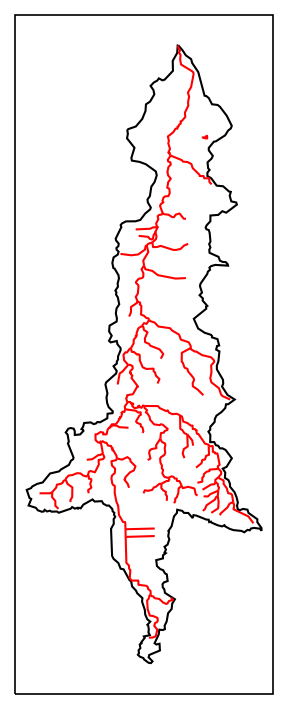

In [38]:
# plot what we have so far -- an image of the HUC and its stream network
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)

plt.show()

2020-09-03 09:54:23,688 - root - INFO: 
2020-09-03 09:54:23,689 - root - INFO: Meshing
2020-09-03 09:54:23,690 - root - INFO: ------------------------------
2020-09-03 09:54:23,690 - root - INFO: Triangulating...
2020-09-03 09:54:23,698 - root - INFO:    1003 points and 1003 facets
2020-09-03 09:54:23,699 - root - INFO:  checking graph consistency
2020-09-03 09:54:23,699 - root - INFO:  tolerance is set to 1
2020-09-03 09:54:23,704 - root - INFO:  building graph data structures
2020-09-03 09:54:23,710 - root - INFO:  triangle.build...
2020-09-03 09:54:23,711 - root - WARNING: Triangulate: '--enforce-delaunay' option requires a hacked `meshpy.triangle`.  Proceeding without this option because it is not recognized.
2020-09-03 09:55:16,966 - root - INFO:   ...built: 59884 mesh points and 118410 triangles
2020-09-03 09:55:16,967 - root - INFO: Plotting triangulation diagnostics
2020-09-03 09:55:26,814 - root - INFO:   min area = 15.09521484375
2020-09-03 09:55:26,822 - root - INFO:   max a

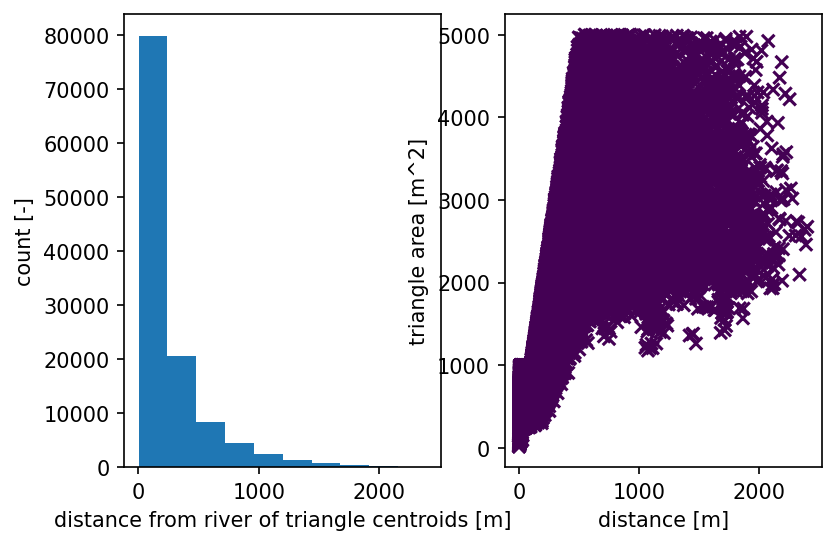

In [39]:
# form a triangulation on the shape + river network

# triangulation refinement:
# Refine triangles if their area (in m^2) is greater than A(d), where d is the 
# distance from the triangle centroid to the nearest stream.
# A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and
# linearly interpolates between the two endpoints.
d0 = 100; d1 = 500
A0 = 1000; A1 = 5000
#A0 = 500; A1 = 2500
#A0 = 100; A1 = 500

# Refine triangles if they get too acute
min_angle = 32 # degrees

# make 2D mesh
mesh_points2, mesh_tris, d = workflow.triangulate(watershed, rivers, 
                                               refine_distance=[d0,A0,d1,A1],
                                               refine_min_angle=min_angle,
                                               enforce_delaunay=True,
                                               diagnostics=True)
#mesh_points2, mesh_tris, d = workflow.triangulate(watershed, rivers,
#                                                 refine_max_area=100000,
#                                                 enforce_delaunay=True,
#                                                 diagnostics=True)

## Download DEM

In [33]:
# get a raster for the elevation map, based on NED
dem_profile, dem = workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs)

2020-09-02 23:33:10,441 - root - INFO: 
2020-09-02 23:33:10,442 - root - INFO: Preprocessing Raster
2020-09-02 23:33:10,442 - root - INFO: ------------------------------
2020-09-02 23:33:10,443 - root - INFO: collecting raster
2020-09-02 23:33:10,606 - root - INFO: Collecting DEMs to tile bounds: [-83.76334689085509, 40.72496193156285, -83.59124707234115, 41.05028410192222]
2020-09-02 23:33:10,607 - root - INFO:   Need:
2020-09-02 23:33:10,607 - root - INFO:     /Users/shua784/Dropbox/github/watershed-workflow/examples/data/dem/USGS_NED_13as_n41_w084.img
2020-09-02 23:33:10,608 - root - INFO:     /Users/shua784/Dropbox/github/watershed-workflow/examples/data/dem/USGS_NED_13as_n42_w084.img
2020-09-02 23:33:12,020 - root - INFO: Attempting to download source for target '/Users/shua784/Dropbox/github/watershed-workflow/examples/data/dem/USGS_NED_13as_n41_w084.img'
2020-09-02 23:33:12,021 - root - INFO: Downloading: "https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/IMG/USGS_NED

### Map mesh to DEM

In [40]:
# elevate the triangle nodes to the dem
mesh_points3 = workflow.elevate(mesh_points2, crs, dem, dem_profile)

2020-09-03 09:55:53,028 - root - INFO: 
2020-09-03 09:55:53,028 - root - INFO: Elevating Triangulation to DEM
2020-09-03 09:55:53,029 - root - INFO: ------------------------------


Plotting the resulting mesh can be done in a variety of ways, including both 3D plots and mapview.  We show both here, but hereafter use mapview plots as they are a bit clearer (if not so flashy)...

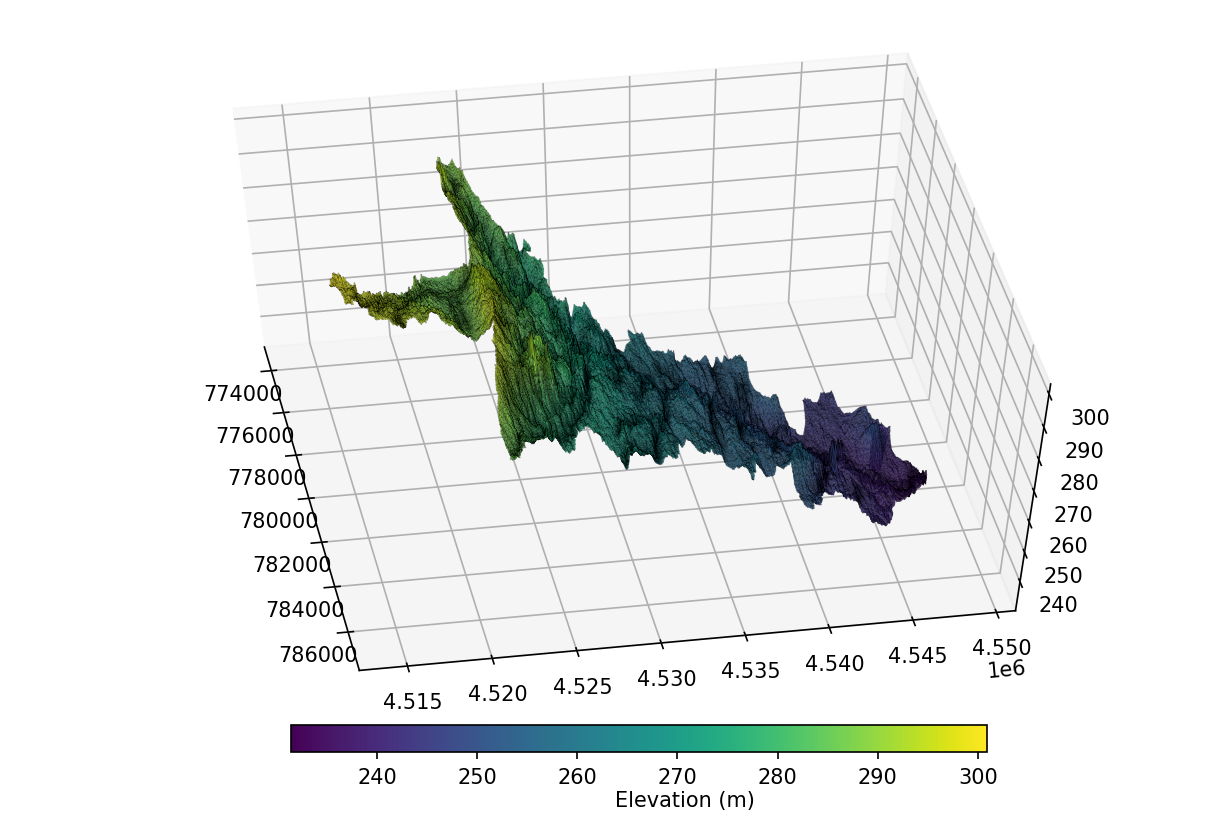

In [147]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize_3d)
ax = workflow.plot.get_ax('3d', fig, window=[0.0,0.2,1,0.8])
cax = fig.add_axes([0.23,0.18,0.58,0.03])

mp = ax.plot_trisurf(mesh_points3[:,0], mesh_points3[:,1], mesh_points3[:,2], 
                     triangles=mesh_tris, cmap='viridis', 
                     edgecolor=(0,0,0,.2), linewidth=0.5)
cb = fig.colorbar(mp, orientation="horizontal", cax=cax)

# t = cax.set_title('elevation [m]')
plt.text(0.5, -0.1, 'Elevation (m)', transform=ax.transAxes)

ax.view_init(55,-10)
# ax.set_xticklabels(list())
# ax.set_yticklabels(list())

fig.savefig(fig_mesh3D, dpi = 300, transparent= True)

(746730.4199098211, 800062.5084368913)
(4497646.744, 4565662.976000001)


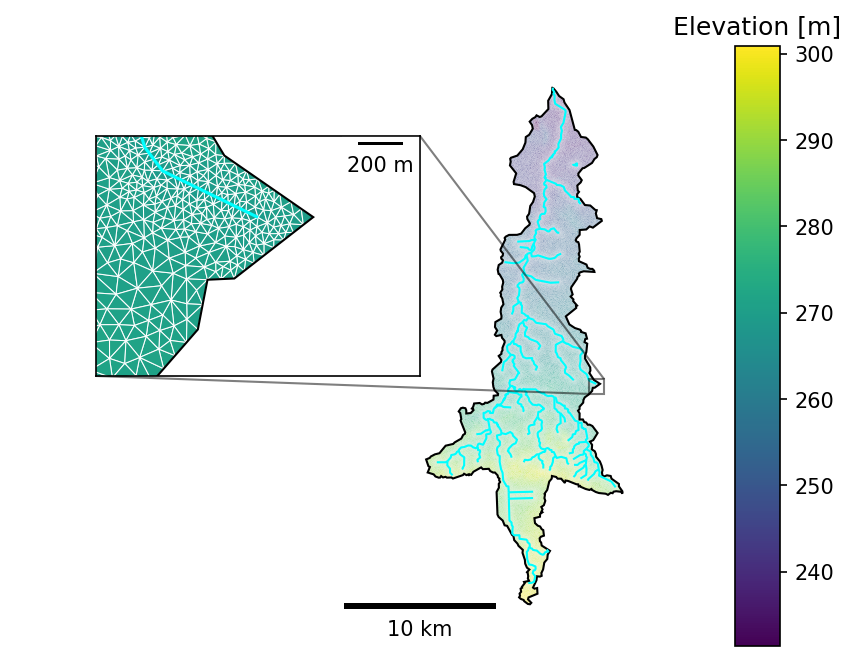

In [142]:
# plot the resulting surface mesh
fig = plt.figure(figsize=(6,5))
ax = workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
#ax2 = workflow.plot.get_ax(crs,fig, window=[0.65,0.05,0.3,0.5])
ax2 = ax.inset_axes([0.1,0.45,0.4,0.4])
# cbax = fig.add_axes([0.05,0.05,0.9,0.05])
cbax = fig.add_axes([0.85,0.1,0.05,0.8])

xlim = (784500., 785500.)
ylim = (4528500., 4529500.)

mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color='elevation', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='aqua', linewidth=1)
ax.set_aspect('equal', 'datalim')
# ax.set_xlim([770000, 800000])
# ax.set_ylim([4520000, 4550000])

mp2 = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
                                 color='elevation', edgecolor='white', linewidth=0.5)
workflow.plot.hucs(watershed, crs, ax=ax2, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax2, color='aqua', linewidth=1.5)
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_aspect('equal', 'datalim')

ax.indicate_inset_zoom(ax2, edgecolor='k')

ax.margins(0.5)
ax.axis('off')
# add scalebar, use 1 for UTM coordinates, the default unit is "m"
scalebar1 = ScaleBar(1, location = "lower center")
scalebar2 = ScaleBar(1, location = "upper right")
ax.add_artist(scalebar1)
ax2.add_artist(scalebar2)

print(ax.get_xlim())
print(ax.get_ylim())
cbar.ax.set_title('Elevation [m]')

# fig.tight_layout()
fig.savefig(fig_mesh, dpi = 300, transparent = True)

### add HRU to mesh

In [154]:
with fiona.open(fname_hru, mode='r') as fid:
    profile = fid.profile
    HRUs = [r for (i,r) in fid.items()]

HRUs_shp = [workflow.utils.shply(i) for i in HRUs]

# -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
#    properties
target_bounds = watershed.exterior().bounds
HRU_ids = np.array([shp['properties']['OBJECTID'] for shp in HRUs], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
color_raster, color_profile, img_bounds = \
            workflow.color_raster_from_shapes(target_bounds, 10, HRUs_shp,
                                              HRU_ids, crs)

# -- resample the raster to the triangles
HRU_colors = workflow.values_from_raster(m2.centroids(), crs, 
                                         color_raster, color_profile)

2020-09-04 16:28:15,411 - root - INFO: Coloring shapes onto raster:
2020-09-04 16:28:15,412 - root - INFO:   target_bounds = (773799.0395860532, 4514650.80208132, 786729.4863051237, 4548658.917701305)
2020-09-04 16:28:15,413 - root - INFO:   out_bounds = [773794.0, 4514654.0, 786744.0, 4548664.0]
2020-09-04 16:28:15,413 - root - INFO:   pixel_size = 10
2020-09-04 16:28:15,413 - root - INFO:   width = 1295, height = 3401
2020-09-04 16:28:15,414 - root - INFO:   and 2643 independent colors of dtype int32


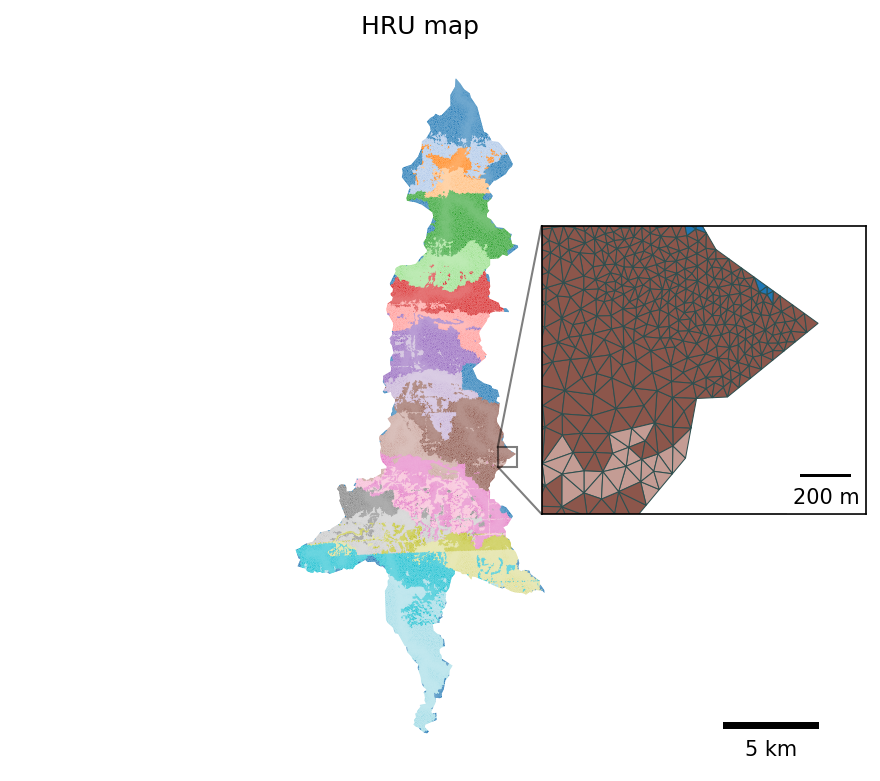

In [163]:
# plot the HRU map overlay with meshes
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
ax2 = ax.inset_axes([0.65,0.35,0.4,0.4])
box_xlim = (784300., 785300.)
box_ylim = (4528500., 4529500.)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                                 linewidth=0, color=HRU_colors, cmap='tab20')
# ax.set_xlim([655000, 695000])
# ax.set_ylim([4550000, 4580000])
ax.set_aspect('equal', 'datalim')

mp2 = workflow.plot.mesh(m2, crs, ax=ax2, facecolor='color',edgecolor = 'darkslategray',
                                 linewidth=0.5, color=HRU_colors, cmap='tab20')
ax2.set_xlim(box_xlim)
ax2.set_ylim(box_ylim)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_aspect('equal', 'datalim')

ax.indicate_inset_zoom(ax2, edgecolor='k')

ax.set_title('HRU map')

ax.axis('off')

scalebar1 = ScaleBar(1, location = "lower right")
scalebar2 = ScaleBar(1, location = "lower right")
ax.add_artist(scalebar1)
ax2.add_artist(scalebar2)

fig.savefig(fig_hru, dpi = 300, transparent = True)

### construct 2d mesh 

In [46]:
# construct the 2D mesh
m2 = workflow.mesh.Mesh2D(mesh_points3.copy(), list(mesh_tris))

### Hydrologically condition the mesh

max diff =  11.933724494195445


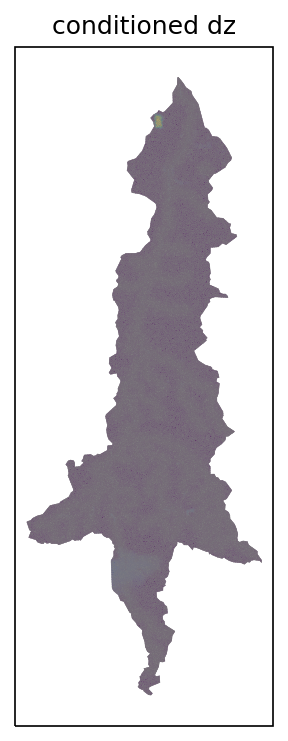

In [47]:
# hydrologically condition the mesh
workflow.condition.condition(m2)

# plot the change between the two meshes
diff = np.copy(mesh_points3)
diff[:,2] = m2.points[:,2] - mesh_points3[:,2] 
print("max diff = ", np.abs(diff[:,2]).max())
fig, ax = workflow.plot.get_ax(crs, figsize=figsize)
workflow.plot.triangulation(diff, m2.conn, crs, color='elevation', edgecolors='gray', 
                            linewidth=0.2, ax=ax)
ax.set_title('conditioned dz')
plt.show()

### Export surface mesh

In [112]:
m2.write_VTK(fname_surface_mesh)

## Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed.

In [48]:
# download the NLCD raster
lc_profile, lc_raster = workflow.get_raster_on_shape(sources['land cover'], 
                                                     watershed.exterior(), crs)

# resample the raster to the triangles
lc = workflow.values_from_raster(m2.centroids(), crs, lc_raster, lc_profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(lc.dtype))
logging.info('Found land cover types: {}'.format(set(lc)))


2020-09-03 10:11:30,499 - root - INFO: 
2020-09-03 10:11:30,500 - root - INFO: Preprocessing Raster
2020-09-03 10:11:30,500 - root - INFO: ------------------------------
2020-09-03 10:11:30,501 - root - INFO: collecting raster
2020-09-03 10:11:30,510 - root - INFO: CRS: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["meters",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
2020-09-03 10:11:30,774 - root - INFO: Got raster of shape: (1162, 453)
2020-09-03 10:11:30,774 - root - IN

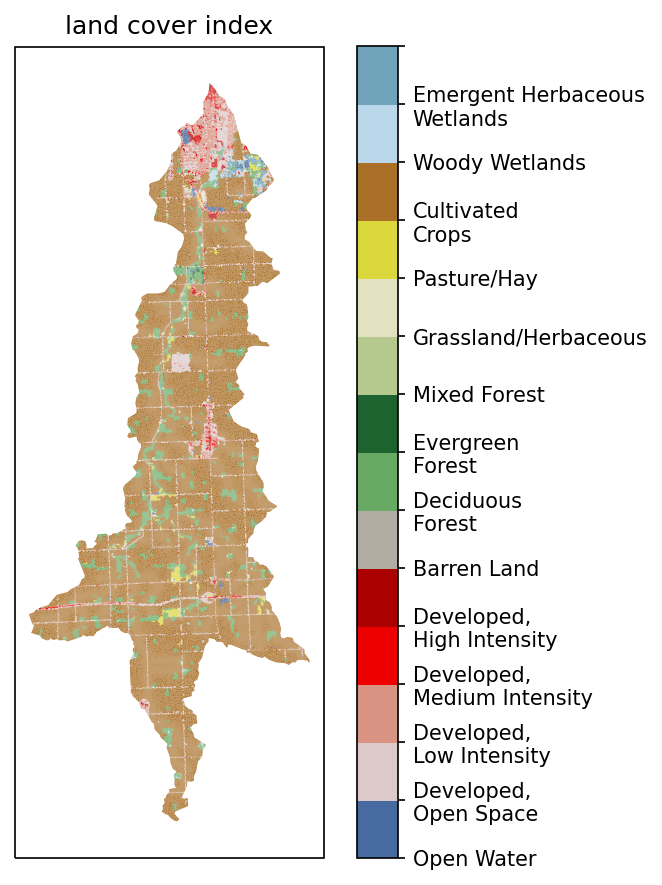

In [116]:
# plot the NLCD data

# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                workflow.colors.generate_nlcd_colormap(lc)

# this is just hacking the label names to make them display a bit neater for a cleaner plot
nlcd_labels_fw = []
for label in nlcd_labels:
    label_fw = label
    if len(label) > 15:
        if ' ' in label:
            lsplit = label.split()
            if len(lsplit) == 2:
                label_fw = '\n'.join(lsplit)
            elif len(lsplit) == 4:
                label_fw = '\n'.join([' '.join(lsplit[0:2]),
                                      ' '.join(lsplit[2:])])
            elif len(lsplit) == 3:
                if len(lsplit[0]) > len(lsplit[-1]):
                    label_fw = '\n'.join([lsplit[0],
                                          ' '.join(lsplit[1:])])
                else:
                    label_fw = '\n'.join([' '.join(lsplit[:-1]),
                                          lsplit[-1]])
    nlcd_labels_fw.append(label_fw)

# plot the image
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

polys = workflow.plot.mesh(m2, crs, ax=ax, color=lc, cmap=nlcd_cmap, norm=nlcd_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)
mp = pcm.ScalarMappable(norm=nlcd_norm, cmap=nlcd_cmap)
cb = fig.colorbar(mp)
cb.set_ticks(nlcd_ticks)
cb.set_ticklabels(nlcd_labels_fw)
ax.set_title("land cover index")
fig.tight_layout()
fig.savefig(fig_land_cover, dpi = 300, transparent = True)

## Subsurface properties

Get soil structure from SSURGO

In [50]:
# download the NRCS soils data as shapes and project it onto the mesh
import workflow.sources.manager_nrcs
import matplotlib.cm

# -- download the shapes
target_bounds = watershed.exterior().bounds
_, soil_survey = workflow.get_shapes(sources['soil type'], target_bounds, crs)

# -- log the bounds targetted and found
logging.info('target bounds: {}'.format(target_bounds))
logging.info('shape union bounds: {}'.format(
    shapely.ops.cascaded_union(soil_survey).bounds))

# -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
#    properties
soil_ids = np.array([shp.properties['id'] for shp in soil_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
soil_color_raster, soil_color_profile, img_bounds = \
            workflow.color_raster_from_shapes(target_bounds, 10, soil_survey,
                                              soil_ids, crs)

# -- resample the raster to the triangles
soil_color = workflow.values_from_raster(m2.centroids(), crs, 
                                         soil_color_raster, soil_color_profile)

2020-09-03 10:15:07,461 - root - INFO: 
2020-09-03 10:15:07,462 - root - INFO: Preprocessing Shapes
2020-09-03 10:15:07,462 - root - INFO: ------------------------------
2020-09-03 10:15:07,715 - root - INFO:   Using filename: /Users/shua784/Dropbox/github/watershed-workflow/examples/data/soil_survey/soil_survey_shape_-83.7576_40.7328_-83.5889_41.0432.gml
2020-09-03 10:15:07,716 - root - INFO:   Downloading via request.
2020-09-03 10:17:21,015 - fiona._env - ERROR: OpenSSL SSL_read: Connection reset by peer, errno 54
2020-09-03 10:17:21,906 - root - INFO:   Found 4943 shapes.
2020-09-03 10:17:21,907 - root - INFO:   and crs: {'init': 'epsg:4326'}
2020-09-03 10:55:08,277 - root - INFO: target bounds: (773799.0395860532, 4514650.80208132, 786729.4863051237, 4548658.917701305)
2020-09-03 10:55:40,668 - root - INFO: shape union bounds: (762250.9058113865, 4503690.9562639985, 802581.5828173882, 4562291.658522848)
2020-09-03 10:55:40,671 - root - INFO: Coloring shapes onto raster:
2020-09-03

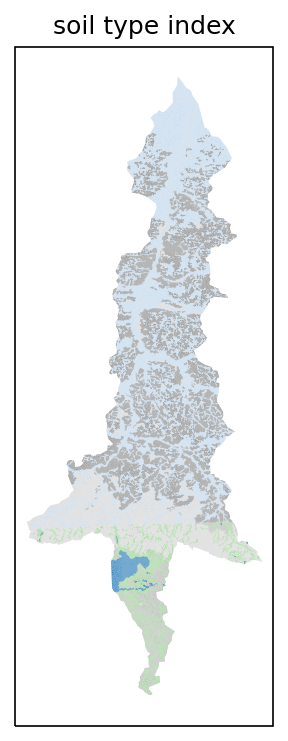

In [115]:
# plot the soil data
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                                 linewidth=0, color=soil_color, cmap='tab20c')
ax.set_title('soil type index')

fig.savefig(fig_soil_type, dpi = 300, transparent = True)

## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

In [53]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []
z = 0.0

# -- soil layer --
#  top 6 m
#  5 cm initial top cell
#  10 cells
#  expanding dz, growing with depth
ncells = 10
dz = 2
layer_dz = 100 # total top thickness

tele = workflow.mesh.telescope_factor(ncells, dz, layer_dz)
print("Got telescoping factor: {}".format(tele))
for i in range(ncells):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(soil_color)
    z += dz
    dz *= tele
    
# # one more 2m layer makes 6m
# dz = 2.0
# layer_types.append('constant')
# layer_data.append(dz)
# layer_ncells.append(1)
# layer_mat_ids.append(soil_color)
# z += dz

# # -- geologic layer --
# # keep going for 2m cells until we hit the bottom of
# # the domain
# layer_types.append("constant")
# layer_data.append(40 - z) # depth of bottom of domain is 40 m
# layer_ncells.append(int(round(layer_data[-1] / dz)))
# layer_mat_ids.append(999*np.ones_like(soil_color))

# print the summary
workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

2020-09-03 11:09:12,732 - root - INFO: Cell summary:
2020-09-03 11:09:12,733 - root - INFO: ------------------------------------------------------------
2020-09-03 11:09:12,733 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2020-09-03 11:09:12,733 - root - INFO: ------------------------------------------------------------
2020-09-03 11:09:12,734 - root - INFO:  00 	| 00 	| 2765005 	|   2.000000 	|   0.000000
2020-09-03 11:09:12,734 - root - INFO:  01 	| 01 	| 2765005 	|   2.664464 	|   2.000000
2020-09-03 11:09:12,734 - root - INFO:  02 	| 02 	| 2765005 	|   3.549685 	|   4.664464
2020-09-03 11:09:12,735 - root - INFO:  03 	| 03 	| 2765005 	|   4.729004 	|   8.214149
2020-09-03 11:09:12,735 - root - INFO:  04 	| 04 	| 2765005 	|   6.300131 	|  12.943153
2020-09-03 11:09:12,736 - root - INFO:  05 	| 05 	| 2765005 	|   8.393237 	|  19.243284
2020-09-03 11:09:12,736 - root - INFO:  06 	| 06 	| 2765005 	|  11.181739 	|  27.636520
2020-09-03 11:09:12,736 - root - INFO:  07 	| 07 	| 276500

Got telescoping factor: 1.33223209954444


In [54]:
# extrude
m3 = workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

### add sidesets from land cover type

In [55]:
# add back on land cover side sets
surf_ss = m3.side_sets[1]

for index, name in zip(nlcd_indices, nlcd_labels):
    where = np.where(lc == index)[0]
    ss = workflow.mesh.SideSet(name, int(index), 
                            [surf_ss.elem_list[w] for w in where],
                            [surf_ss.side_list[w] for w in where])        
    m3.side_sets.append(ss)

In [57]:
# save to disk
try:
    os.remove(fname_final_mesh)
except FileNotFoundError:
    pass
m3.write_exodus(fname_final_mesh)


You are using exodus.py v 1.19.1 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: ./meshes/EagleCreek_final_mesh.exo
Closing exodus file: ./meshes/EagleCreek_final_mesh.exo
